<a href="https://colab.research.google.com/github/AbduzZami/ColabNotebooks/blob/main/Polyp_Seg_DeepLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
balraj98_cvcclinicdb_path = kagglehub.dataset_download('balraj98/cvcclinicdb')
balraj98_automatic_polyp_detection_in_colonoscopic_frames_path = kagglehub.notebook_output_download('balraj98/automatic-polyp-detection-in-colonoscopic-frames')

print('Data source import complete.')


Data source import complete.


## Introduction

### In this notebook we use [DeepLab+](https://arxiv.org/abs/1802.02611) for Polyp Segmentation on [CVC-ClinicDB](https://www.kaggle.com/balraj98/cvcclinicdb) Dataset.

### Libraries 📚⬇

In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [3]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

### Read Data & Create train / valid splits 📁

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/cvcclinicdb")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/cvcclinicdb/versions/1


In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

DATA_DIR = '/root/.cache/kagglehub/datasets/balraj98/cvcclinicdb/versions/1'

# Load metadata
metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[['frame_id', 'png_image_path', 'png_mask_path']]

# Update paths
metadata_df['png_image_path'] = metadata_df['png_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['png_mask_path'] = metadata_df['png_mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))

# Shuffle dataset
metadata_df = metadata_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into train (90%) and test (10%)
train_df, test_df = train_test_split(metadata_df, test_size=0.1, random_state=42)

# Further split train into train (90%) and validation (10%)
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Print sizes
len(train_df), len(valid_df), len(test_df)

(495, 55, 62)

In [6]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['class_names'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'polyp']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Shortlist specific classes to segment

In [7]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'polyp']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'polyp']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Helper functions for viz. & one-hot encoding/decoding

In [8]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [9]:
class EndoscopyDataset(torch.utils.data.Dataset):

    """CVC-ClinicDB Endoscopic Colonoscopy Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """
    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_paths = df['png_image_path'].tolist()
        self.mask_paths = df['png_mask_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

#### Visualize Sample Image and Mask 📈

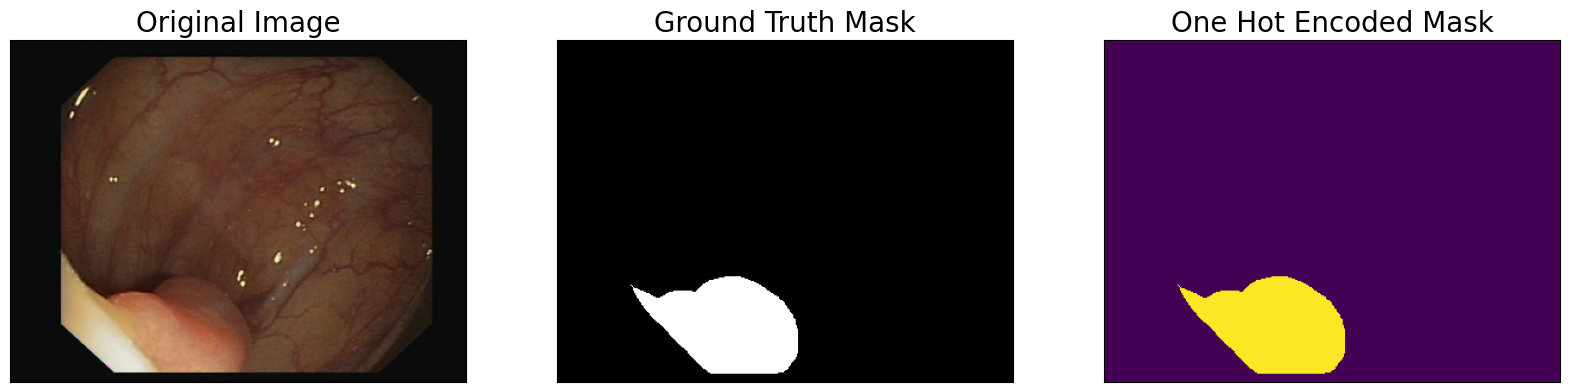

In [10]:
dataset = EndoscopyDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining Augmentations 🙃

In [11]:
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=288, min_width=384, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

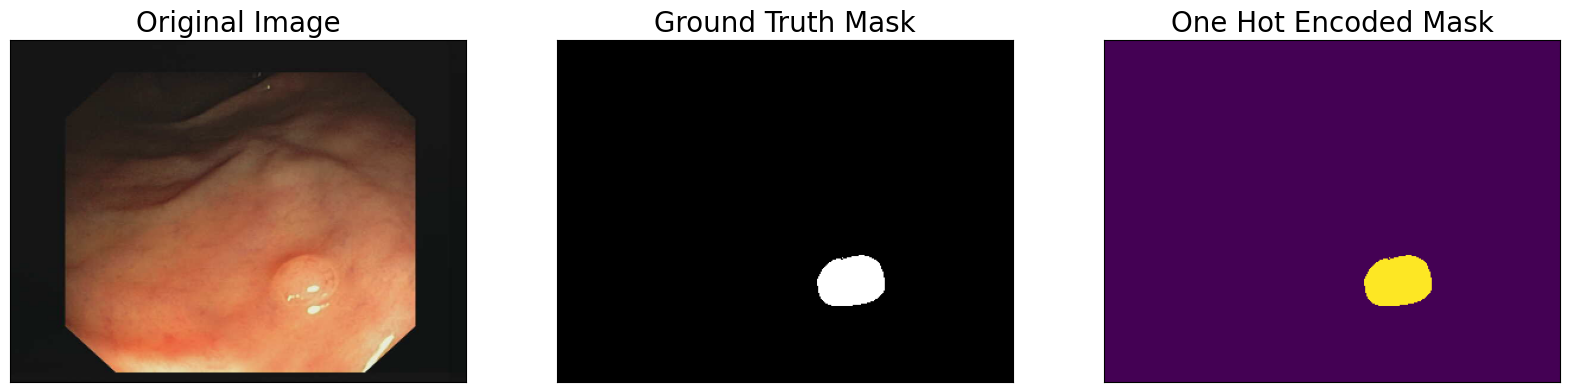

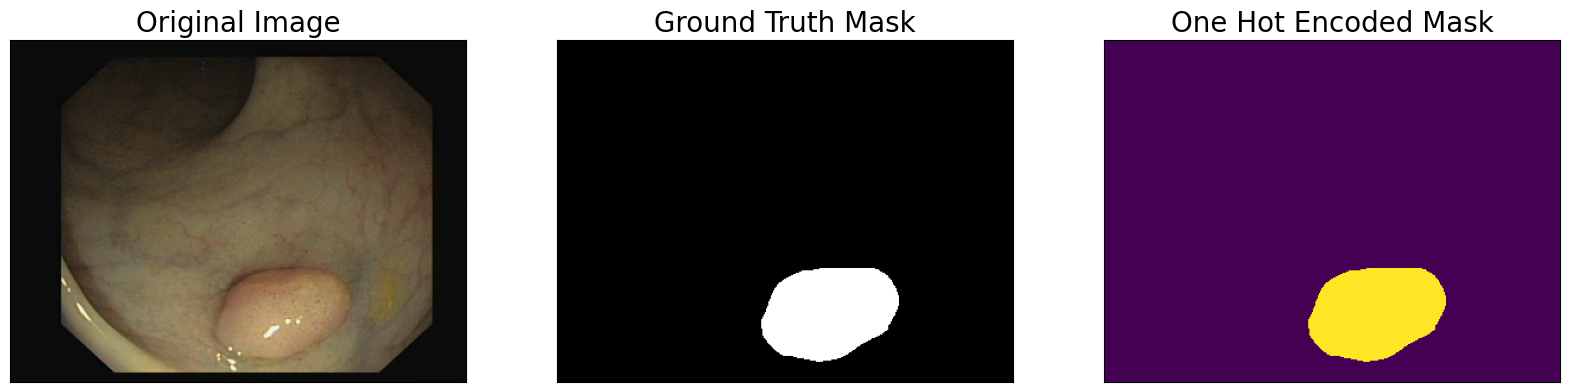

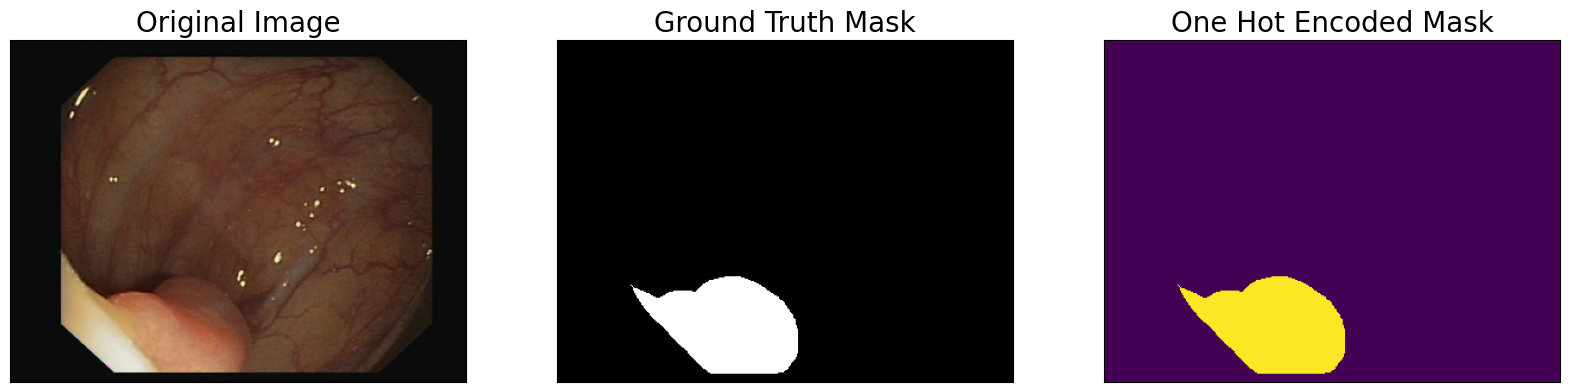

In [12]:
augmented_dataset = EndoscopyDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Training DeepLabV3+

<h3><center>DeepLabV3+ Model Architecture</center></h3>
<img src="https://miro.medium.com/max/1000/1*2mYfKnsX1IqCCSItxpXSGA.png" width="750" height="750"/>
<h4></h4>
<h4><center><a href="https://arxiv.org/abs/1802.02611">Image Source: DeepLabV3+ [Liang-Chieh Chen et al.]</a></center></h4>

### Model Definition

In [13]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [14]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

26677842


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [16]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(ASPP, self).__init__()
        modules = []
        # 1x1 convolution
        modules.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ))

        # Atrous convolutions
        for rate in atrous_rates:
            modules.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=rate, dilation=rate, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))

        # Image-level features (global average pooling)
        modules.append(nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ))

        self.convs = nn.ModuleList(modules)

        # Projection layer
        self.project = nn.Sequential(
            nn.Conv2d(len(modules) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res[-1] = F.interpolate(res[-1], size=res[0].size()[2:], mode='bilinear', align_corners=True)
        res = torch.cat(res, dim=1)
        return self.project(res)

In [17]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 1, bias=False),  # Reduce channels to 48
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(304, out_channels, 3, padding=1, bias=False),  # 256 + 48 = 304
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, low_level_feat):
        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = torch.cat((x, low_level_feat), dim=1)
        x = self.conv2(x)
        return x

In [18]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, encoder_name='resnet50', encoder_weights='imagenet', classes=21, activation='sigmoid', output_stride=16):
        super(DeepLabV3Plus, self).__init__()
        if output_stride not in [8, 16]:
            raise ValueError("output_stride must be 8 or 16")

        # Load the ResNet50 backbone
        self.encoder = models.resnet50(pretrained=encoder_weights == 'imagenet')
        self.output_stride = output_stride

        # Adjust the dilation rates in the ResNet50 backbone
        if output_stride == 16:
            # No dilation in layer4
            self.encoder.layer4[0].conv2.stride = (1, 1)
            self.encoder.layer4[0].downsample[0].stride = (1, 1)
        elif output_stride == 8:
            # No dilation in layer3 and layer4
            self.encoder.layer3[0].conv2.stride = (1, 1)
            self.encoder.layer3[0].downsample[0].stride = (1, 1)
            self.encoder.layer4[0].conv2.stride = (1, 1)
            self.encoder.layer4[0].downsample[0].stride = (1, 1)

        # Remove the fully connected layer and average pooling layer
        self.encoder.fc = nn.Identity()  # Remove the fully connected layer
        self.encoder.avgpool = nn.Identity()  # Remove the average pooling layer

        # ASPP module
        if output_stride == 16:
            self.aspp = ASPP(2048, 256, [6, 12, 18])
        elif output_stride == 8:
            self.aspp = ASPP(2048, 256, [12, 24, 36])

        # Decoder module
        self.decoder = Decoder(256, 256)

        # Final classification layer
        self.final_conv = nn.Conv2d(256, classes, 1)

        # Activation function
        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'softmax2d':
            self.activation = nn.Softmax2d()
        else:
            self.activation = None

    def forward(self, x):
        input_size = x.size()[2:]

        # Encoder
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        x = self.encoder.maxpool(x)

        x1 = self.encoder.layer1(x)  # Low-level features
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x4 = self.encoder.layer4(x3)  # High-level features

        # ASPP
        x = self.aspp(x4)

        # Decoder
        x = self.decoder(x, x1)

        # Final upsampling
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)
        x = self.final_conv(x)

        # Activation
        if self.activation is not None:
            x = self.activation(x)

        return x

In [19]:
# Define the model
model = DeepLabV3Plus(encoder_name='resnet50', encoder_weights='imagenet', classes=len(CLASSES), activation=ACTIVATION, output_stride=16)

# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 40347298


#### Get Train / Val DataLoaders

In [20]:
# Get train and val dataset instances
train_dataset = EndoscopyDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = EndoscopyDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4)

#### Set Hyperparams

In [21]:

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 100

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
from segmentation_models_pytorch.losses import DiceLoss
loss = DiceLoss(mode='binary')
loss.__name__ = 'dice_loss'

class DiceCoefficient(torch.nn.Module):
    def __init__(self, threshold=0.5):
        super(DiceCoefficient, self).__init__()
        self.threshold = threshold
        self.__name__ = "DiceCoefficient"  # Add the __name__ attribute

    def forward(self, y_true, y_pred):
        y_pred = torch.sigmoid(y_pred)  # Apply sigmoid if predictions are logits
        y_pred = (y_pred > self.threshold).float()  # Apply threshold

        intersection = (y_true * y_pred).sum(dim=(2, 3))  # Sum over height and width
        union = (y_true + y_pred).sum(dim=(2, 3))

        dice = 2. * intersection / (union + 1e-6)  # Add epsilon to avoid division by zero
        return dice.mean()  # Mean over the batch





# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5), # This line caused the error. Replaced with the correct import below
    DiceCoefficient(threshold=0.5),
    # smp.metrics.iou_score # Updated import for IoU metric
    # smp.metrics.iou_score  # Use the correct class for IoU metric
]
# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=1e-9,
)

import torch
import segmentation_models_pytorch as smp
import os

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# model.load_state_dict(torch.load("/content/best_model.pth", map_location=DEVICE, weights_only=False))
model.to(DEVICE)
print("Model successfully loaded!")

Model successfully loaded!


In [22]:
class ThresholdedDiceLoss(torch.nn.Module):
    def __init__(self, threshold=0.5):
        super(ThresholdedDiceLoss, self).__init__()
        self.threshold = threshold
        self.__name__ = 'dice_loss'  # Add the __name__ attribute

    def forward(self, y_true, y_pred):
        # Apply sigmoid if the predictions are logits (before thresholding)
        y_pred = torch.sigmoid(y_pred)

        # Apply thresholding to the predicted probabilities
        y_pred = (y_pred > self.threshold).float()

        # Calculate intersection and union
        intersection = (y_true * y_pred).sum(dim=(2, 3))  # Sum over height and width
        union = (y_true + y_pred).sum(dim=(2, 3))

        # Calculate Dice coefficient and return the loss (1 - Dice coefficient)
        dice = 2. * intersection / (union + 1e-6)  # Add epsilon to avoid division by zero
        return 1 - dice.mean()  # Loss is 1 - Dice coefficient, averaged over the batch


loss = ThresholdedDiceLoss(threshold=0.5)

In [23]:
!pip install -q -U torch torchvision segmentation-models-pytorch albumentations

import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
# Importing utils from segmentation_models_pytorch

from segmentation_models_pytorch.losses import DiceLoss

# ... other code ...

train_epoch = utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

### Training UNet

In [ ]:
class EarlyStopping:
    def __init__(self, patience=40, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.wait = 0
        self.stopped_epoch = 0
        self.stop_training = False

    def __call__(self, current_loss):
        if self.best_loss is None:
            self.best_loss = current_loss
        elif self.best_loss - current_loss > self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stop_training = True
                self.stopped_epoch = epoch

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# Modify the training loop to include early stopping
if TRAINING:
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for epoch in range(EPOCHS):
        print('\nEpoch: {}'.format(epoch))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model.state_dict(), 'best_model.pth')
            # torch.save(model, './best_model.pth')
            print('Model saved!')

        Early stopping check
        early_stopping(valid_logs['dice_loss'])
        if early_stopping.stop_training:
            print(f"Early stopping triggered at epoch {epoch}!")
            break


Epoch: 0
valid: 100%|██████████| 7/7 [00:02<00:00,  2.95it/s, dice_loss - 0.227, iou_score - 0.8737, DiceCoefficient - 0.773]
Model saved!

Epoch: 1
valid: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s, dice_loss - 0.2627, iou_score - 0.7789, DiceCoefficient - 0.7373]

Epoch: 2
valid: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s, dice_loss - 0.1405, iou_score - 0.9153, DiceCoefficient - 0.8595]
Model saved!

Epoch: 3
valid: 100%|██████████| 7/7 [00:01<00:00,  3.74it/s, dice_loss - 0.1478, iou_score - 0.9113, DiceCoefficient - 0.8522]

Epoch: 4
valid: 100%|██████████| 7/7 [00:01<00:00,  3.75it/s, dice_loss - 0.1205, iou_score - 0.9245, DiceCoefficient - 0.8795]
Model saved!

Epoch: 5
valid: 100%|██████████| 7/7 [00:01<00:00,  3.75it/s, dice_loss - 0.2645, iou_score - 0.8501, DiceCoefficient - 0.7355]

Epoch: 6
valid: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s, dice_loss - 0.09082, iou_score - 0.9354, DiceCoefficient - 0.9092]
Model saved!

Epoch: 7
valid: 100%|██████████| 7/7 [00:01<0

In [ ]:
# %%time

# if TRAINING:

#     best_iou_score = 0.0
#     train_logs_list, valid_logs_list = [], []

#     for i in range(0, EPOCHS):

#         # Perform training & validation
#         print('\nEpoch: {}'.format(i))
#         train_logs = train_epoch.run(train_loader)
#         valid_logs = valid_epoch.run(valid_loader)
#         train_logs_list.append(train_logs)
#         valid_logs_list.append(valid_logs)

#         # Save model if a better val IoU score is obtained
#         if best_iou_score < valid_logs['iou_score']:
#             best_iou_score = valid_logs['iou_score']
#             torch.save(model, './best_model.pth')
#             print('Model saved!')

### Prediction on Test Data

In [ ]:
# load best saved model checkpoint from the current run
from segmentation_models_pytorch.decoders.deeplabv3.model import DeepLabV3Plus  # Explicitly import the DeepLabV3Plus class
best_model = torch.load('/content/best_model.pth', map_location=DEVICE, weights_only=False)  # Setting weights_only=False in torch.load

model.load_state_dict(torch.load('./best_model.pth'))
model.eval()

best_model = model


# if os.path.exists('/content/best_model.pth'):
#     best_model = torch.load('/content/best_model.pth', map_location=DEVICE)
#     print('Loaded UNet model from this run.')

# # load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('../input/polyp-segmentation-in-colonoscopy-frames-deeplab/best_model.pth'):
#     best_model = torch.load('../input/polyp-segmentation-in-colonoscopy-frames-deeplab/best_model.pth', map_location=DEVICE)
#     print('Loaded UNet model from a previous commit.')

In [ ]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = EndoscopyDataset(
    test_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = EndoscopyDataset(
    test_df,
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides.
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [ ]:
# Center crop padded image / mask to original image dims
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=true_dimensions[0], width=true_dimensions[1])(image=image)

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
# prompt: predict a image by the trained model

# best_model.eval()
# with torch.no_grad():
#   for i in range(len(test_dataset)):
#     image, gt_mask = test_dataset[i]
#     x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
#     pr_mask = best_model(x_tensor)
#     pr_mask = (pr_mask.squeeze().cpu().numpy().round())

#     visualize(
#         original_image = image,
#         ground_truth_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values),
#         predicted_mask = colour_code_segmentation(pr_mask, select_class_rgb_values),
#         one_hot_encoded_mask = reverse_one_hot(gt_mask)
#     )
#     break  # Only predict for one image


In [ ]:
# torch.save(model.state_dict(), 'best_model.pth')
# # Load the state dictionary
# model.load_state_dict(torch.load('best_model.pth'))
# model.eval()

# best_model = model

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_polyp_heatmap = crop_image(pred_mask[:,:,select_classes.index('polyp')], true_dimensions)['image']
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values), true_dimensions)['image']
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values), true_dimensions)['image']
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_polyp_heatmap = pred_polyp_heatmap
    )

### Model Evaluation on Test Dataset

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")
print(f"Mean Dice: {valid_logs['DiceCoefficient']:.4f}")

### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()


In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()